In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lifesim


In [2]:
%pwd

'/home/long/.local/lib/python3.10/site-packages/lifesim/gui'

In [3]:
#LIFEsim is capable of taking an artificial exoplanet catalog input from P-Pop, calculate the signal-to-noise ratio for each planet and distribute the observation time available in the search phase to observe and detect an optimal number of exoplanets

# Create an instance to save all data and parameters in a single location
bus = lifesim.Bus()

# Set the parameters to the baseline case by running
bus.data.options.set_scenario('baseline')


In [4]:
# A example synthetic planet population based on statistics from the Kepler mission can be downloaded from the P-Pop github page
filename = '/home/long/Desktop/Tutorial/Tutorial_1/TestPlanetPopulation.txt'

#P-Pop catalog can be loaded i
bus.data.catalog_from_ppop(filename, overwrite = True)

Processed line 45884 of 45884


In [5]:
#an instance of the LIFEsim instrument module needs to be created
instrument = lifesim.Instrument(name='inst')


In [6]:
#To give any module access to the data and parameters used in a simulation, it needs to be connected to the bus
bus.add_module(instrument)


In [7]:
#All modules needed for the instrument module to run need to be created. Create the module responsible for simulating transmission maps of a four-arm nulling interferometer and add it to the bus
transm = lifesim.TransmissionMap(name='transm')
bus.add_module(transm)

In [8]:
#create the modules for the simulation of the astrophysical noise sources and add them to the bus.
exozodi = lifesim.PhotonNoiseExozodi(name='exo')
bus.add_module(exozodi)
localzodi = lifesim.PhotonNoiseLocalzodi(name='local')
bus.add_module(localzodi)
star_leak = lifesim.PhotonNoiseStar(name='star')
bus.add_module(star_leak)

In [9]:
bus.connect(('inst', 'transm'))
bus.connect(('inst', 'exo'))
bus.connect(('inst', 'local'))
bus.connect(('inst', 'star'))

bus.connect(('star', 'transm'))

In [10]:
#The optimizer is responsible for distributing the available observing time onto the individual stars. Analogously to above, we have

opt = lifesim.Optimizer(name='opt')
bus.add_module(opt)
ahgs = lifesim.AhgsModule(name='ahgs')
bus.add_module(ahgs)

bus.connect(('transm', 'opt'))
bus.connect(('inst', 'opt'))
bus.connect(('opt', 'ahgs'))

In [11]:
#the signal-to-noise ratio needs to be calculated for every planet in the catalog. To do so, we run
instrument.get_snr()


100%|███████████████████████████████████████| 1732/1732 [03:26<00:00,  8.37it/s]


In [12]:
#Knowing the SNR for each planet, the integration time can be optimally distributed by

bus.data.options.optimization['habitable'] = True

In [13]:
# Get basic statistics about the loaded catalog
catalog = bus.data.catalog
print(f"Total catalog entries: {len(catalog)}")
print(f"Catalog columns: {list(catalog.columns)}")


Total catalog entries: 45882
Catalog columns: ['radius_p', 'p_orb', 'mass_p', 'ecc_p', 'inc_p', 'large_omega_p', 'small_omega_p', 'theta_p', 'albedo_bond', 'albedo_geom_vis', 'albedo_geom_mir', 'z', 'semimajor_p', 'sep_p', 'angsep', 'maxangsep', 'flux_p', 'fp', 'temp_p', 'radius_s', 'mass_s', 'temp_s', 'distance_s', 'ra', 'dec', 'nuniverse', 'nstar', 'stype', 'id', 'name_s', 'lon', 'lat', 's_in', 's_out', 'l_sun', 'hz_in', 'hz_out', 'hz_center', 'habitable', 'snr_1h', 'baseline']


=== Planet Type Distribution ===
Earth-like (0.8-1.2 R⊕): 10030
Super-Earths (1.2-2.0 R⊕): 10942
Sub-Neptunes (2.0-4.0 R⊕): 10024
Neptunes (4.0-10.0 R⊕): 1775
Jupiters (>10.0 R⊕): 137


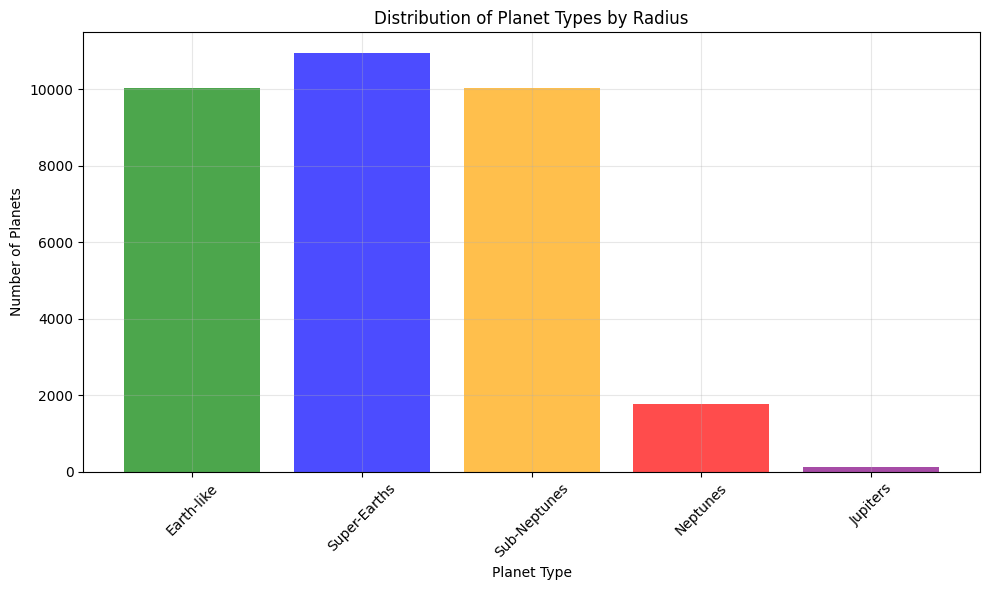

In [14]:
# Analyze planet and star properties
# First, let's see what columns are available for analysis
distance_cols = [col for col in catalog.columns if 'distance' in col.lower() or 'dist' in col.lower()]
radius_cols = [col for col in catalog.columns if 'radius' in col.lower() or 'rad' in col.lower()]
mass_cols = [col for col in catalog.columns if 'mass' in col.lower()]

# Analyze different planet types based on radius
if radius_cols:
    radius_col = radius_cols[0]
    radii = catalog[radius_col].dropna()

    # Define planet categories
    earth_like = (radii >= 0.8) & (radii <= 1.2)
    super_earths = (radii > 1.2) & (radii <= 2.0)
    sub_neptunes = (radii > 2.0) & (radii <= 4.0)
    neptunes = (radii > 4.0) & (radii <= 10.0)
    jupiters = radii > 10.0

    print("=== Planet Type Distribution ===")
    print(f"Earth-like (0.8-1.2 R⊕): {earth_like.sum()}")
    print(f"Super-Earths (1.2-2.0 R⊕): {super_earths.sum()}")
    print(f"Sub-Neptunes (2.0-4.0 R⊕): {sub_neptunes.sum()}")
    print(f"Neptunes (4.0-10.0 R⊕): {neptunes.sum()}")
    print(f"Jupiters (>10.0 R⊕): {jupiters.sum()}")

    # Plot planet type distribution
    plt.figure(figsize=(10, 6))
    categories = ['Earth-like', 'Super-Earths', 'Sub-Neptunes', 'Neptunes', 'Jupiters']
    counts = [earth_like.sum(), super_earths.sum(), sub_neptunes.sum(), neptunes.sum(), jupiters.sum()]

    plt.bar(categories, counts, alpha=0.7, color=['green', 'blue', 'orange', 'red', 'purple'])
    plt.xlabel('Planet Type')
    plt.ylabel('Number of Planets')
    plt.title('Distribution of Planet Types by Radius')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

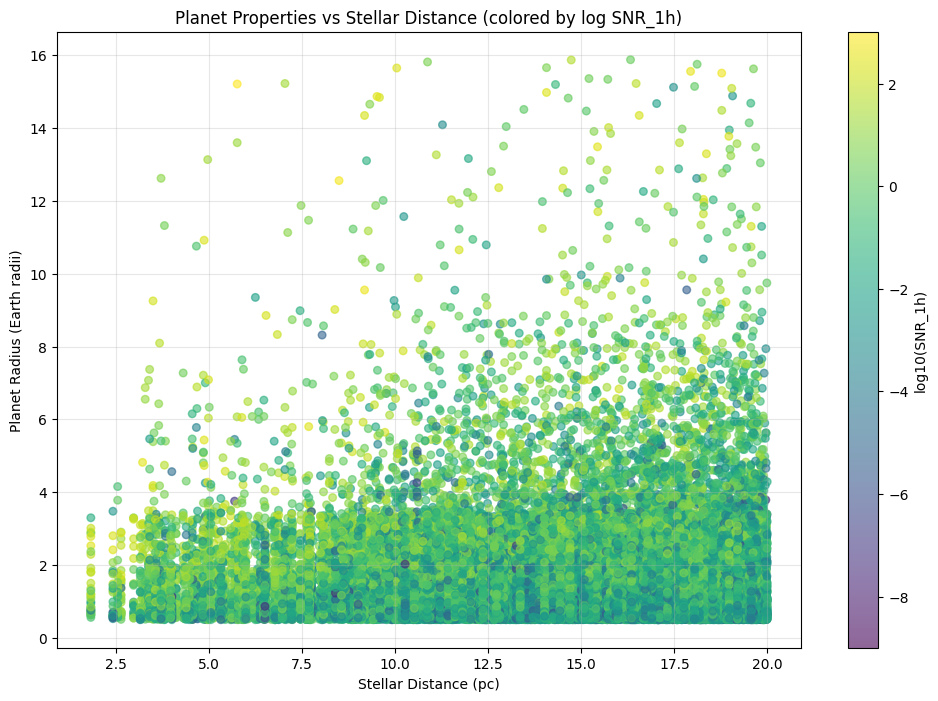

Plotted 45882 planets
Distance range: 1.8 - 20.0 pc
Radius range: 0.50 - 15.87 Earth radii


In [15]:
# Create scatter plot
plt.figure(figsize=(12, 8))

# Use distance_s, radius_p, and snr_1h
distances = catalog['distance_s']
radii = catalog['radius_p']
snr_values = catalog['snr_1h']

# Remove any potential NaN values
valid_mask = ~(distances.isna() | radii.isna() | snr_values.isna())
valid_data = catalog[valid_mask]

distances_clean = valid_data['distance_s']
radii_clean = valid_data['radius_p']
snr_clean = valid_data['snr_1h']

# Use log scale for SNR colors to handle the wide range
snr_log = np.log10(snr_clean + 1e-10)  # Add small value to avoid log(0)

scatter = plt.scatter(distances_clean, radii_clean, c=snr_log, cmap='viridis', alpha=0.6, s=30)
cbar = plt.colorbar(scatter, label='log10(SNR_1h)')
plt.xlabel('Stellar Distance (pc)')
plt.ylabel('Planet Radius (Earth radii)')
plt.title('Planet Properties vs Stellar Distance (colored by log SNR_1h)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Plotted {len(distances_clean)} planets")
print(f"Distance range: {distances_clean.min():.1f} - {distances_clean.max():.1f} pc")
print(f"Radius range: {radii_clean.min():.2f} - {radii_clean.max():.2f} Earth radii")

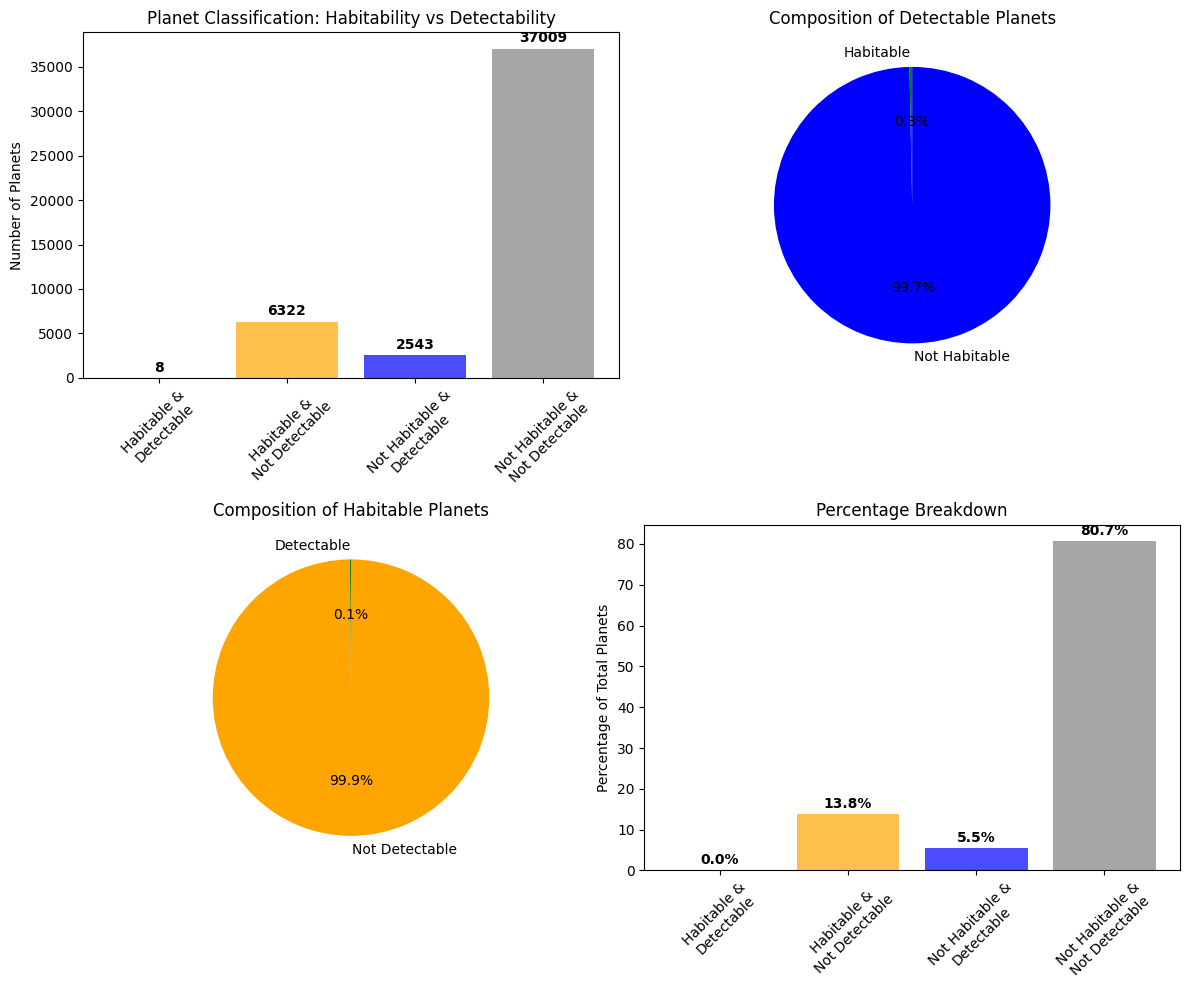

=== Summary Statistics ===
Total planets: 45882
Habitable planets: 6330 (13.8%)
Detectable planets: 2551 (5.6%)
Habitable AND detectable: 8 (0.02%)


In [16]:
# Detectability vs Habitability plots
hab_detectable = catalog[(catalog['habitable'] == True) & (catalog['snr_1h'] >= 7)]
hab_not_detectable = catalog[(catalog['habitable'] == True) & (catalog['snr_1h'] < 7)]
not_hab_detectable = catalog[(catalog['habitable'] == False) & (catalog['snr_1h'] >= 7)]
not_hab_not_detectable = catalog[(catalog['habitable'] == False) & (catalog['snr_1h'] < 7)]

# Create a 2x2 bar plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

categories = ['Habitable &\nDetectable', 'Habitable &\nNot Detectable', 'Not Habitable &\nDetectable', 'Not Habitable &\nNot Detectable']
counts = [len(hab_detectable), len(hab_not_detectable), len(not_hab_detectable), len(not_hab_not_detectable)]
colors = ['green', 'orange', 'blue', 'gray']

# Main summary plot
ax1.bar(categories, counts, color=colors, alpha=0.7)
ax1.set_ylabel('Number of Planets')
ax1.set_title('Planet Classification: Habitability vs Detectability')
ax1.tick_params(axis='x', rotation=45)
for i, v in enumerate(counts):
    ax1.text(i, v + max(counts)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

# Pie chart of detectable planets
detectable_data = [len(hab_detectable), len(not_hab_detectable)]
detectable_labels = ['Habitable', 'Not Habitable']
ax2.pie(detectable_data, labels=detectable_labels, colors=['green', 'blue'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Composition of Detectable Planets')

# Pie chart of habitable planets
habitable_data = [len(hab_detectable), len(hab_not_detectable)]
habitable_labels = ['Detectable', 'Not Detectable']
ax3.pie(habitable_data, labels=habitable_labels, colors=['green', 'orange'], autopct='%1.1f%%', startangle=90)
ax3.set_title('Composition of Habitable Planets')

# Percentage breakdown
total_planets = len(catalog)
percentages = [count/total_planets*100 for count in counts]
ax4.bar(categories, percentages, color=colors, alpha=0.7)
ax4.set_ylabel('Percentage of Total Planets')
ax4.set_title('Percentage Breakdown')
ax4.tick_params(axis='x', rotation=45)
for i, v in enumerate(percentages):
    ax4.text(i, v + max(percentages)*0.01, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
total_habitable = (catalog['habitable'] == True).sum()
total_detectable = (catalog['snr_1h'] >= 7).sum()
print(f"=== Summary Statistics ===")
print(f"Total planets: {len(catalog)}")
print(f"Habitable planets: {total_habitable} ({100*total_habitable/len(catalog):.1f}%)")
print(f"Detectable planets: {total_detectable} ({100*total_detectable/len(catalog):.1f}%)")
print(f"Habitable AND detectable: {len(hab_detectable)} ({100*len(hab_detectable)/len(catalog):.2f}%)")